#**과제: 차원 축소 실습 및 시각화**



###**차원축소 실습**
1. 코드의 과정을 이해하고 주석 및 빈칸을 채워주세요
2. 최적의 주성분 또는 latent space를 정해서 차원축소를 진행하고 그 이유를 서술해주세요


PCA

원하는 분산 설명 비율을 정하고 시각화를 진행해 필요한 주성분 개수를 정해봅시다!

In [2]:
from sklearn.datasets import load_digits

In [3]:
digits = load_digits()
X = digits.data
y = digits.target

import numpy as np

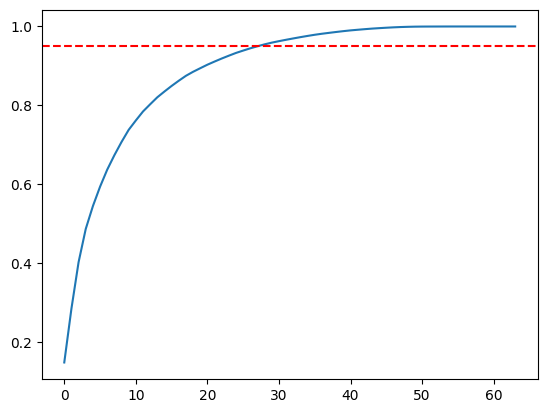

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

##1. 데이터의 각 특성별 평균을 빼서 중앙에 몰리도록(centered) 변환
X_mean=X-np.mean(X,axis=0)

##2. SVD(Singular Value Decomposition)를 사용하여 중심화된 데이터를 분해
U,S,Vt=np.linalg.svd(X_mean)

##3. Vt 행렬을 전치하여 주성분(Principal components)을 추출
principle_components=Vt.T

##4. 각 주성분의 분산과 누적 분산 설명 비율을 계산
explained_variance = (S ** 2) / (X.shape[0] - 1)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumsum = np.cumsum(explained_variance_ratio)

plt.plot(cumsum)

##5. 누적 분산 설명 비율이 95%에 도달하는 지점을 임계값(Threshold)으로 표시
plt.axhline(y=0.95, color="r", linestyle="--", label="Threshold")


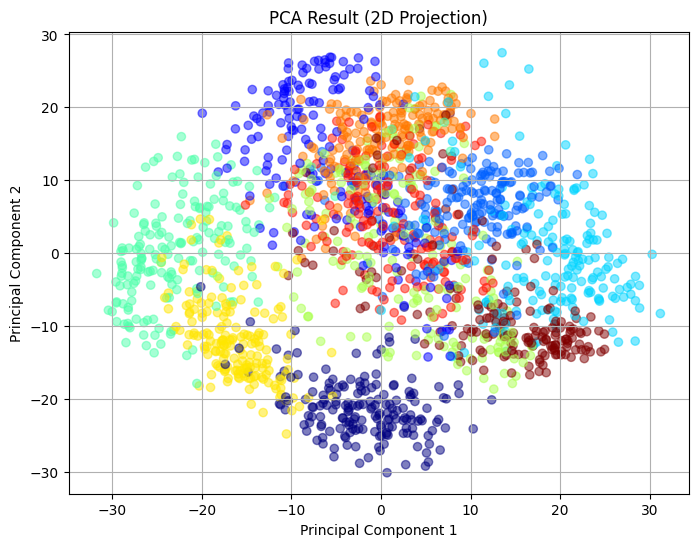

In [5]:
##6. 분산 설명 비율을 만족하는 주성분 개수까지 eigen vector를 잘라봅시다
n_components = np.argmax(cumsum >= 0.95) + 1
principle_components= Vt[:n_components].T

##7. 중심화된 데이터를 선택된 주성분(고유 벡터)에 투영하여 차원 축소된 데이터를 얻는다.
X_pca=np.dot(X_mean,principle_components)

##8. 2차원 시각화이지만, 원하신다면 변형하셔도 됩니다.
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1],  c=y, cmap="jet", alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Result (2D Projection)")
plt.grid(True)
plt.show()

문제. PCA에서는 어떤 주성분을 사용하셨나요? 그리고 그 이유는 뭔가요?

답: PCA에서는 데이터의 누적 분산 설명 비율이 95% 이상이 되는 주성분들을 사용하였다. 그 이유는 이 주성분들이 원본 데이터의 95% 이상의 변동성을 포착함으로써 중요한 정보는 대부분 유지하면서 차원을 효과적으로 축소할 수 있기 때문이다.

LDA

선택된 최적의 n_components: 8


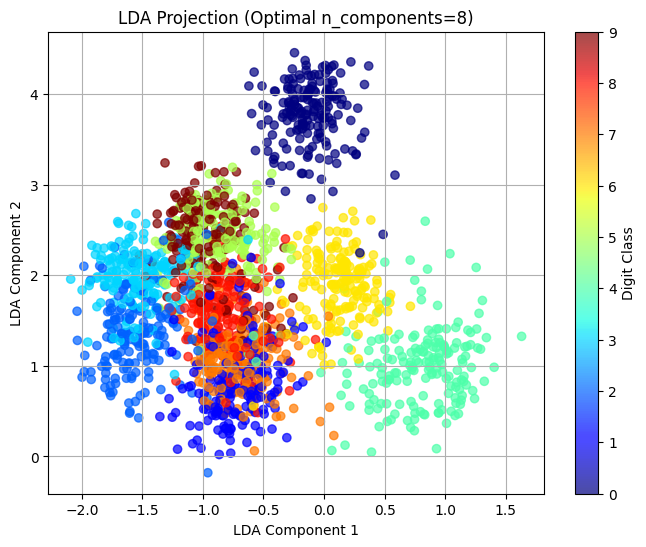

In [6]:
##1. X 데이터의 평균을 뺴서 데이터의 중심을 0으로 맞추는 중심화(Center normalization)를 수행
X_scaled = X-np.mean(X)

##2. 각 클래스별로 스캐일된 데이터의 평균 벡터를 계산
class_labels = np.unique(y)
mean_vectors = [np.mean(X_scaled[y == label], axis=0) for label in class_labels]
mean_vectors = np.array(mean_vectors)

##3. 클래스 내 산포행렬(S_W; Within-Class Scatter Matrix)을 계산한다.
S_W = np.zeros((X.shape[1], X.shape[1]))
for label, mean_vec in zip(class_labels, mean_vectors):
    class_scatter = np.zeros((X.shape[1], X.shape[1]))
    for row in X_scaled[y == label]:
        row = row.reshape(-1, 1)
        mean_vec = mean_vec.reshape(-1, 1)
        class_scatter += (row - mean_vec) @ (row - mean_vec).T
    S_W += class_scatter

##4. 전체 평균을 기준으로 각 클래스별 평균 벡터의 편차를 반영한 클래스 간 산포행렬(S_B; Between-Class Scatter Matrix)을 계산
overall_mean = np.mean(X_scaled, axis=0).reshape(-1, 1)
S_B = np.zeros((X.shape[1], X.shape[1]))
for label, mean_vec in zip(class_labels, mean_vectors):
    mean_vec = mean_vec.reshape(-1, 1)
    n = X_scaled[y == label].shape[0]
    S_B += n * (mean_vec - overall_mean) @ (mean_vec - overall_mean).T

##5. S_W의 역행렬을 구하고, 이를 사용해 행렬 M = S_W^-1 * S_B
U, S, Vt = np.linalg.svd(S_W)
S_inv = np.diag(1 / S)
S_W_inv = Vt.T @ S_inv @ U.T

M = S_W_inv @ S_B
eigenvalues, eigenvectors = np.linalg.eig(M)


idx = np.argsort(-eigenvalues.real)
eigenvalues = eigenvalues[idx].real
eigenvectors = eigenvectors[:, idx].real

##6. 각 고유값이 설명하는 분산 비율과 누적 분산 설명 비율을 계산
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

##5. 누적 분산 설명 비율이 95% 이상이 되는 주성분 개수를 선택
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"선택된 최적의 n_components: {n_components}")

##6. 선택된 n_components 개수에 해당하는 eigenvector를 사용해 LDA 변환 행렬 W_lda를 구성하고, 데이터를 해당 축으로 투영
W_lda = eigenvectors[:, :n_components]
X_lda = X_scaled @ W_lda


plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap="jet", alpha=0.7)
plt.colorbar(scatter, label="Digit Class")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.title(f"LDA Projection (Optimal n_components={n_components})")
plt.grid()
plt.show()


Autoencoder

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset


##1. 데이터를 표준화하여 학습에 적합한 형태로 변환하고, PyTorch의 DataLoader를 이용해 배치 학습을 위한 데이터셋을 구성
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)


dataset = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

##2. Autoencoder 클래스를 정의합니다.
##   인코더는 입력 데이터를 저차원의 잠재 공간(latent space)으로 압축하고,
##   디코더는 이 잠재 표현으로부터 원래 입력 데이터를 재구성
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=2):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

##3. 디바이스 설정 및 모델, 손실함수, 옵티마이저를 정의
##   CUDA 사용 가능시 GPU를 사용하고, MSE 손실 함수를 기준으로 Adam 옵티마이저로 모델을 최적화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(latent_dim=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

문제. LDA에서는 어떤 주성분을 사용하셨나요? 그리고 그 이유는 뭔가요?

답: LDA에서는 S_W⁻¹S_B 행렬의 고유벡터 중 누적 분산 설명 비율이 95% 이상인 주성분을 사용했습니다.\
이 주성분들은 클래스 간의 차이를 가장 잘 나타내어, 데이터를 효과적으로 구분할 수 있도록 해주기 때문입니다.

Autoencoder-분류기를 통한 성능 평가

Latent Dim: 2, Accuracy: 0.6939
Latent Dim: 3, Accuracy: 0.8375
Latent Dim: 4, Accuracy: 0.6478
Latent Dim: 5, Accuracy: 0.8994
Latent Dim: 6, Accuracy: 0.8953


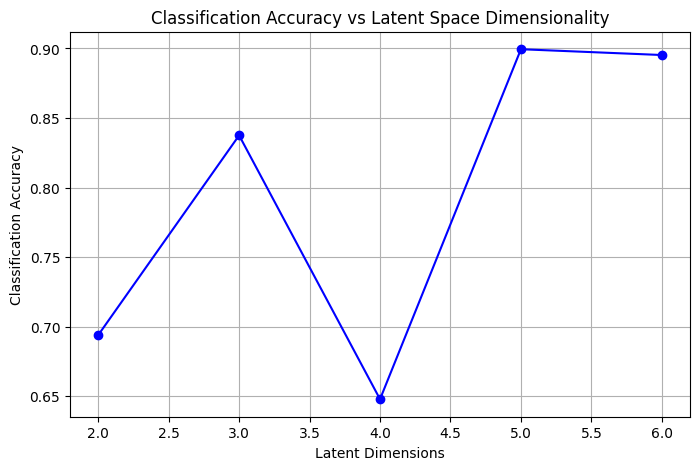

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

##원하는 latent_dims로 실험해보세요!!
latent_dims = [2, 3, 4, 5, 6]  ##eg. latent_dims[3,4]
accuracies = []

##learning rate 조절하셔도 됩니다
for dim in latent_dims:
    model = Autoencoder(latent_dim=dim).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    accuracy=0

##epoch 조절하셔도 됩니다
    for i in range(0,10):
      num_epochs = 20
      for epoch in range(num_epochs):
          for X_batch, _ in data_loader:
              X_batch = X_batch.to(device)
              recon, _ = model(X_batch)
              loss = criterion(recon, X_batch)

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()


      X_encoded = []
      y_labels = []
      with torch.no_grad():
          for X_batch, y_batch in data_loader:
              X_batch = X_batch.to(device)
              _, z = model(X_batch)
              X_encoded.append(z.cpu().numpy())
              y_labels.append(y_batch.numpy())

      X_encoded = np.vstack(X_encoded)
      y_labels = np.hstack(y_labels)

      ##분류기로 성능 평가를 진행해보겠습니다
      X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_labels, test_size=0.2, random_state=42)
      clf = RandomForestClassifier(n_estimators=100, random_state=42)
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      accuracy += accuracy_score(y_test, y_pred)

    accuracies.append(accuracy/10)

    print(f"Latent Dim: {dim}, Accuracy: {accuracy/10:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(latent_dims, accuracies, marker="o", linestyle="-", color="b")
plt.xlabel("Latent Dimensions")
plt.ylabel("Classification Accuracy")
plt.title("Classification Accuracy vs Latent Space Dimensionality")
plt.grid()
plt.show()

Autoencoder 결과 시각화

원하는 latent space를 지정해서 시각화를 진행해봅시다

Epoch [1/20], Loss: 29.0259
Epoch [2/20], Loss: 27.5494
Epoch [3/20], Loss: 28.2357
Epoch [4/20], Loss: 26.6809
Epoch [5/20], Loss: 26.5710
Epoch [6/20], Loss: 26.3064
Epoch [7/20], Loss: 26.1131
Epoch [8/20], Loss: 25.9372
Epoch [9/20], Loss: 25.1721
Epoch [10/20], Loss: 27.2931
Epoch [11/20], Loss: 24.3895
Epoch [12/20], Loss: 23.9389
Epoch [13/20], Loss: 23.6533
Epoch [14/20], Loss: 23.7763
Epoch [15/20], Loss: 23.2158
Epoch [16/20], Loss: 23.0767
Epoch [17/20], Loss: 23.0722
Epoch [18/20], Loss: 22.9841
Epoch [19/20], Loss: 22.8690
Epoch [20/20], Loss: 22.7996


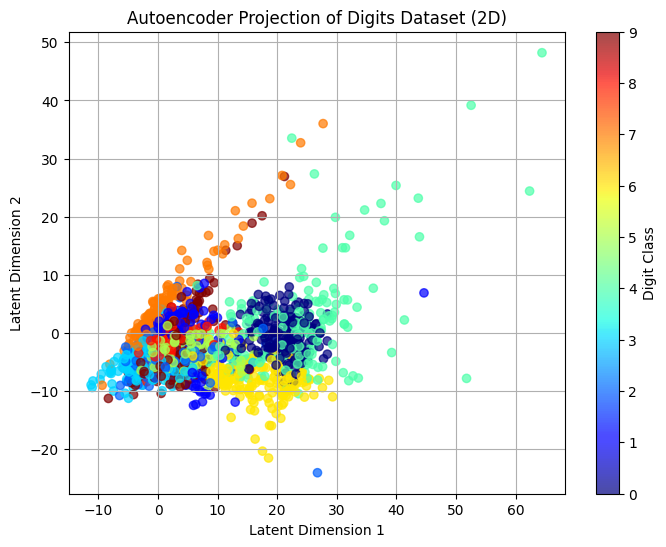

In [9]:
model = Autoencoder(latent_dim=6).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, _ in data_loader:
        X_batch = X_batch.to(device)
        recon, _ = model(X_batch)
        loss = criterion(recon, X_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

X_encoded = []
y_labels = []

with torch.no_grad():
    for X_batch, y_batch in data_loader:
        X_batch = X_batch.to(device)
        _, z = model(X_batch)
        X_encoded.append(z.cpu().numpy())
        y_labels.append(y_batch.numpy())

X_encoded = np.vstack(X_encoded)
y_labels = np.hstack(y_labels)


plt.figure(figsize=(8, 6))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=y_labels, cmap="jet", alpha=0.7)
plt.colorbar(label="Digit Class")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Autoencoder Projection of Digits Dataset (2D)")
plt.grid()
plt.show()

문제. Autoencoder에서는 어떤 latent space를 사용하셨나요? 그리고 그 이유는 뭔가요?

답: Autoencoder에서는 입력 데이터의 중요한 특징만을 보존하면서 차원을 크게 줄일 수 있는 낮은 차원의 latent space(예: 2차원)를 사용했습니다.
이렇게 선택한 이유는, 저차원으로 압축함으로써 데이터의 핵심 정보를 추출하고 노이즈를 제거하며, 시각화나 분류와 같은 후속 작업에서 효율적으로 활용할 수 있기 때문입니다.

###**T-SNE를 이용한 시각화**
PCA와 t-SNE의 차원 축소 결과를 시각화하고 비교해보세요. 답 작성란은 아래에 있습니다:)

In [10]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd

data_digit= datasets.load_digits()

df_digit = pd.DataFrame(data = data_digit['data'], columns=data_digit['feature_names'])
label_digit = data_digit['target']

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(n_components=2)

df_digit_tsne=pd.DataFrame(data=tsne.fit_transform(df_digit),columns=["col1","col2"])
df_digit_tsne["label"]=label_digit

scaler=StandardScaler()
df_digit_scaled=pd.DataFrame(data=scaler.fit_transform(df_digit))

pca=PCA(n_components=2)
df_digit_pca=pd.DataFrame(data=pca.fit_transform(df_digit_scaled),columns=["col1","col2"])


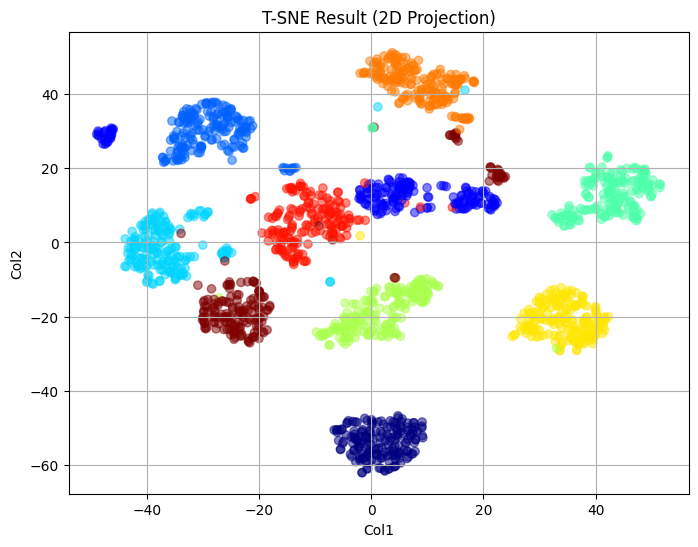

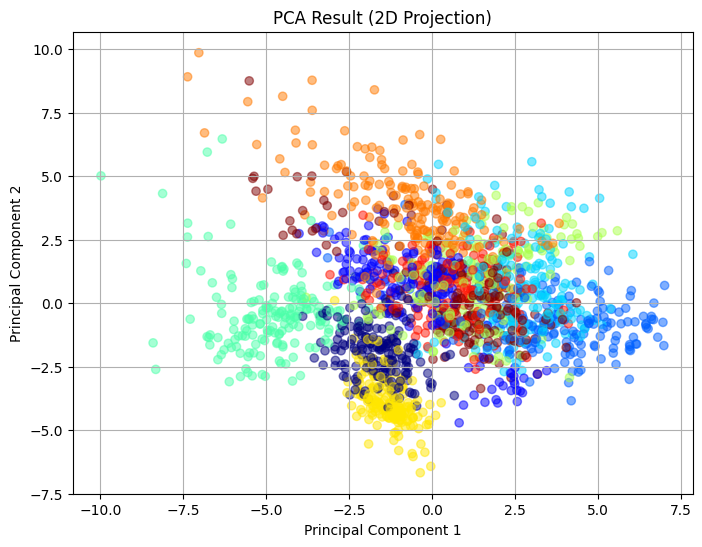

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(df_digit_tsne['col1'], df_digit_tsne['col2'],  c=label_digit, cmap="jet", alpha=0.5)
plt.xlabel("Col1")
plt.ylabel("Col2")
plt.title("T-SNE Result (2D Projection)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df_digit_pca['col1'], df_digit_pca['col2'],  c=label_digit, cmap="jet", alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Result (2D Projection)")
plt.grid(True)
plt.show()

문제. 어떤 차원축소 기법이 더 좋은 시각화 결과를 냈는지, 이 이유가 무엇인지 서술하세요

답: t-SNE가 더 좋은 시각화 결과를 보입니다.
그 이유는 t-SNE는 데이터의 지역적(로컬) 구조와 이웃 간의 유사도를 보존하는 비선형 차원 축소 기법으로, 군집 간의 미세한 차이를 강조하여 각 클래스가 명확하게 분리되는 시각화를 제공합니다. 반면, PCA는 전체 분산을 최대화하는 선형 방법이라서 복잡한 데이터의 비선형 관계를 충분히 반영하지 못해 클래스 구분이 덜 뚜렷하게 나타납니다.